In [1]:
#run from the root directory
import os

os.chdir("..")

In [2]:
import pandas as pd
import numpy as np
from config import *

df = pd.read_csv("./data/domain_dataset.csv")

### Readability Score

In [41]:
import re 

readability = []

for i in range(4):
    doc = list(df.iloc[i*20000:(i+1)*20000]['text'])
    # doc = [re.sub(r'[^\w]', ' ', x.lower()) for x in doc]

    _readability = []
    for i in range(len(doc)):
        _readability.append(textstat.flesch_reading_ease(doc[i]))
    
    readability.append(_readability)
    


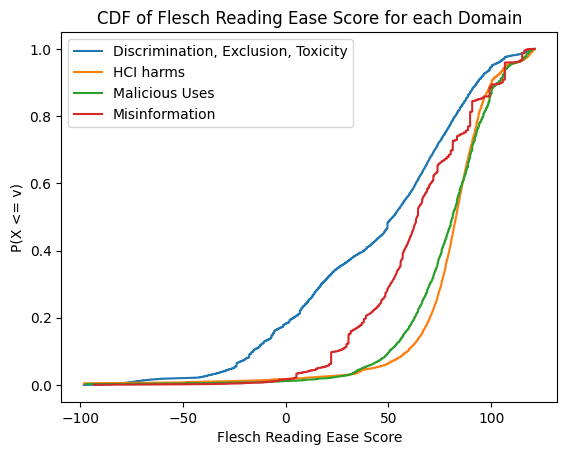

In [107]:
def calculate_cdf(array, plot_range):
    # Sort the full array
    sorted_array = np.sort(array)
    # Calculate the cumulative sum of probabilities
    cdf = np.arange(1, len(sorted_array) + 1) / len(sorted_array)
    # Limit the array and CDF to the plot range for plotting
    limited_sorted_array = sorted_array[(sorted_array >= plot_range[0]) & (sorted_array <= plot_range[1])]
    limited_cdf = cdf[(sorted_array >= plot_range[0]) & (sorted_array <= plot_range[1])]
    return limited_sorted_array, limited_cdf


DOMAINS = ["Discrimination, Exclusion, Toxicity", "HCI harms", "Malicious Uses", "Misinformation"]
for i in range(4):
    sorted_array, cdf = calculate_cdf(readability[i], (-100, 150))
    plt.plot(sorted_array, cdf, label=DOMAINS[i])

plt.xlabel("Flesch Reading Ease Score")
plt.ylabel("P(X <= v)")
plt.title("CDF of Flesch Reading Ease Score for each Domain")
plt.legend()
plt.show()

### Number of Un-common words

In [47]:
glove_words = []
with open("/nethome/ss651/Robust-LLM/intent/glove.6B.100d.txt", "r") as f:
    for line in f:
        word = line.split()[0]
        glove_words.append(word)

In [67]:
uncommon_words = []

for i in range(4):
    print(i)
    uncommon_words.append([x for x in top_words[i] if x not in glove_words])

for i in range(4):
    print(f"Domain = {DOMAINS[i]} --- Uncommon words = {len(uncommon_words[i])}")

0
1
2
3
Domain = Discrimination, Exclusion, Toxicity --- Uncommon words = 4259
Domain = HCI harms --- Uncommon words = 12551
Domain = Malicious Uses --- Uncommon words = 14950
Domain = Misinformation --- Uncommon words = 17485


### TF-IDF Overlap

In [3]:
domain_text = []

for i in range(4):
    domain_text.append(df.iloc[i*20000:(i+1)*20000])

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

def top_tfidf_words(sentences, top_n=1000):
    # Initialize a TF-IDF Vectorizer
    vectorizer = TfidfVectorizer(stop_words='english')

    # Fit and transform the sentences
    tfidf_matrix = vectorizer.fit_transform(sentences)

    # Get feature names (words)
    feature_names = vectorizer.get_feature_names_out()

    # Sum TF-IDF for each term across all documents
    sums = tfidf_matrix.sum(axis=0)

    # Create a dataframe with words and their corresponding sums
    data = []
    for col, term in enumerate(feature_names):
        data.append((term, sums[0, col]))

    ranking = pd.DataFrame(data, columns=['term', 'rank'])
    ranking = ranking.sort_values('rank', ascending=False)

    return ranking.iloc[0:top_n]['term'].tolist()


In [7]:
top_words = []
top_words_safe = []
top_words_unsafe = []

for i in range(4):
    top_words.append(top_tfidf_words(list(domain_text[i]['text'])))
    top_words_safe.append(top_tfidf_words(domain_text[i][df["binary_label"] == 0]['text']))
    top_words_unsafe.append(top_tfidf_words(domain_text[i][df["binary_label"] == 1]['text']))

/tmp/ipykernel_3479343/372332324.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_words_safe.append(top_tfidf_words(domain_text[i][df["binary_label"] == 0]['text']))
/tmp/ipykernel_3479343/372332324.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_words_unsafe.append(top_tfidf_words(domain_text[i][df["binary_label"] == 1]['text']))
/tmp/ipykernel_3479343/372332324.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_words_safe.append(top_tfidf_words(domain_text[i][df["binary_label"] == 0]['text']))
/tmp/ipykernel_3479343/372332324.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_words_unsafe.append(top_tfidf_words(domain_text[i][df["binary_label"] == 1]['text']))
/tmp/ipykernel_3479343/372332324.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_words_safe.append(top_tfidf_words(domain_text[i][df["bi

In [8]:
for i in range(4):
   print(len(top_words_safe[i]))
   print(len(top_words_unsafe[i]))
   print(len(set(top_words_safe[i]).intersection(set(top_words_unsafe[i]))))  
   print(len(top_words_safe[i]) + len(top_words_unsafe[i]) - len(set(top_words_safe[i]).intersection(set(top_words_unsafe[i]))))
   print()

1000
1000
443
1557

1000
1000
636
1364

1000
1000
668
1332

1000
1000
331
1669



In [22]:
from collections import Counter
import re

for i in range(4):
   common_words = set(top_words_safe[i]) & set(top_words_unsafe[i])
   dtext = domain_text[i]['text'].tolist()
   dtext = " ".join(dtext).lower()
   dtext = re.sub(r'\W+', ' ', dtext)
   dtext = dtext.split()

   word_count = Counter(dtext)
   tsum = 0
   for word in common_words:
       tsum += word_count[word]
   print(f"Domain = {DOMAINS[i]} --- Common words = {len(common_words)} --- Total count = {(len(dtext) - tsum)/20000}")
   print(len(word_count) - len(common_words))
   print()


Domain = Discrimination, Exclusion, Toxicity --- Common words = 2803 --- Total count = 41.7646
16744

Domain = HCI harms --- Common words = 2943 --- Total count = 78.9554
37333

Domain = Malicious Uses --- Common words = 3182 --- Total count = 24.0038
40802

Domain = Misinformation --- Common words = 1944 --- Total count = 99.1726
59366



In [30]:
from collections import Counter

pp = []
for i in range(4):
   common_words = set(top_words_safe[i]) & set(top_words_unsafe[i])
   dtext = domain_text[i]['text'].tolist()

   dtext = [re.sub(r'\W+', ' ', x) for x in dtext]
   dtext = [x.split() for x in dtext]

   nn = []
   for d in dtext:
      word_count = Counter(d)
      total = len(d)
      for word in common_words:
         total -= word_count[word]
      nn.append(total)
   pp.append(nn)
   print(f"Domain = {DOMAINS[i]} --- Common words = {len(common_words)} --- Total count = {sum(nn)/20000}")

Domain = Discrimination, Exclusion, Toxicity --- Common words = 2803 --- Total count = 42.78855
Domain = HCI harms --- Common words = 2943 --- Total count = 80.60765
Domain = Malicious Uses --- Common words = 3182 --- Total count = 26.4122
Domain = Misinformation --- Common words = 1944 --- Total count = 107.34655


In [32]:
indomain_overlap = np.zeros(4,)
overlap_words = []

top_n = 1000

for i in range(4):
   overlap_words.append(set(top_words_safe[i]).intersection(set(top_words_unsafe[i])))
   indomain_overlap[i] = len(overlap_words[i])

   count_safe = 0
   count_unsafe = 0

   safe = domain_text[i][df["binary_label"] == 0]['text'].tolist()
   unsafe = domain_text[i][df["binary_label"] == 1]['text'].tolist()

   safe = [x.lower().split() for x in safe]
   unsafe = [x.lower().split() for x in unsafe]

   for j in range(10000):
      for x in safe[j]:
         if x in overlap_words[i]:
            count_safe += 1
            break

      for x in unsafe[j]:
         if x in overlap_words[i]:
            count_unsafe += 1
            break

   print(f"Domain = {DOMAINS[i]}\n\tOverlap = {indomain_overlap[i]}\n\tTotal Overlap = {count_safe + count_unsafe}")
indomain_overlap

/tmp/ipykernel_3479343/2560854243.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  safe = domain_text[i][df["binary_label"] == 0]['text'].tolist()
/tmp/ipykernel_3479343/2560854243.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unsafe = domain_text[i][df["binary_label"] == 1]['text'].tolist()
/tmp/ipykernel_3479343/2560854243.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  safe = domain_text[i][df["binary_label"] == 0]['text'].tolist()
/tmp/ipykernel_3479343/2560854243.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unsafe = domain_text[i][df["binary_label"] == 1]['text'].tolist()


Domain = Discrimination, Exclusion, Toxicity
	Overlap = 443.0
	Total Overlap = 19547
Domain = HCI harms
	Overlap = 636.0
	Total Overlap = 18388


/tmp/ipykernel_3479343/2560854243.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  safe = domain_text[i][df["binary_label"] == 0]['text'].tolist()
/tmp/ipykernel_3479343/2560854243.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unsafe = domain_text[i][df["binary_label"] == 1]['text'].tolist()


Domain = Malicious Uses
	Overlap = 668.0
	Total Overlap = 18100


/tmp/ipykernel_3479343/2560854243.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  safe = domain_text[i][df["binary_label"] == 0]['text'].tolist()
/tmp/ipykernel_3479343/2560854243.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unsafe = domain_text[i][df["binary_label"] == 1]['text'].tolist()


Domain = Misinformation
	Overlap = 331.0
	Total Overlap = 16270


array([443., 636., 668., 331.])

### Tokenizer Analysis

In [139]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")

In [151]:
for i in range(4):
  # _top = top_words[i]['term'].tolist()
  _top = uncommon_words[i]
  _top_tokens = tokenizer.tokenize(_top, is_split_into_words=True)
  ratio = len(_top_tokens) / len(_top)
  print(f"Domain = {DOMAINS[i]} --- Ratio = {ratio}")


Domain = Discrimination, Exclusion, Toxicity --- Ratio = 3.9328480864052593
Domain = HCI harms --- Ratio = 3.972193450721058
Domain = Malicious Uses --- Ratio = 4.110969899665552
Domain = Misinformation --- Ratio = 4.854732627966829


### Cross Domain Analysis

In [9]:
domain_topwords_safe = []
domain_topwords_unsafe = []

for d in domain_text:
    domain_topwords_safe.append(top_tfidf_words(d[df["binary_label"] == 0]['text']))
    domain_topwords_unsafe.append(top_tfidf_words(d[df["binary_label"] == 1]['text']))
    
overlap_count_safe = np.zeros((4,4))
overlap_count_unsafe = np.zeros((4,4))

for i in range(4):
    for j in range(4):
        overlap_count_safe[i][j] = len(set(domain_topwords_safe[i]).intersection(set(domain_topwords_safe[j])))/len(domain_topwords_safe[i])
        overlap_count_unsafe[i][j] = len(set(domain_topwords_unsafe[i]).intersection(set(domain_topwords_unsafe[j])))/len(domain_topwords_unsafe[i])

overlap_count_safe, overlap_count_unsafe

/tmp/ipykernel_3479343/1873959227.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  domain_topwords_safe.append(top_tfidf_words(d[df["binary_label"] == 0]['text']))
/tmp/ipykernel_3479343/1873959227.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  domain_topwords_unsafe.append(top_tfidf_words(d[df["binary_label"] == 1]['text']))
/tmp/ipykernel_3479343/1873959227.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  domain_topwords_safe.append(top_tfidf_words(d[df["binary_label"] == 0]['text']))
/tmp/ipykernel_3479343/1873959227.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  domain_topwords_unsafe.append(top_tfidf_words(d[df["binary_label"] == 1]['text']))
/tmp/ipykernel_3479343/1873959227.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  domain_topwords_safe.append(top_tfidf_words(d[df["binary_label"] == 0]['text']))
/

(array([[1.   , 0.407, 0.401, 0.213],
        [0.407, 1.   , 0.582, 0.207],
        [0.401, 0.582, 1.   , 0.212],
        [0.213, 0.207, 0.212, 1.   ]]),
 array([[1.   , 0.418, 0.446, 0.347],
        [0.418, 1.   , 0.551, 0.422],
        [0.446, 0.551, 1.   , 0.431],
        [0.347, 0.422, 0.431, 1.   ]]))

In [13]:
DOMAINS

['Discrimination, Exclusion, Toxicity',
 'HCI harms',
 'Malicious Uses',
 'Misinformation']

In [14]:
DOMAINS1 = ["Discrimination", "HCI harms", "Malicious Uses", "Misinformation"]

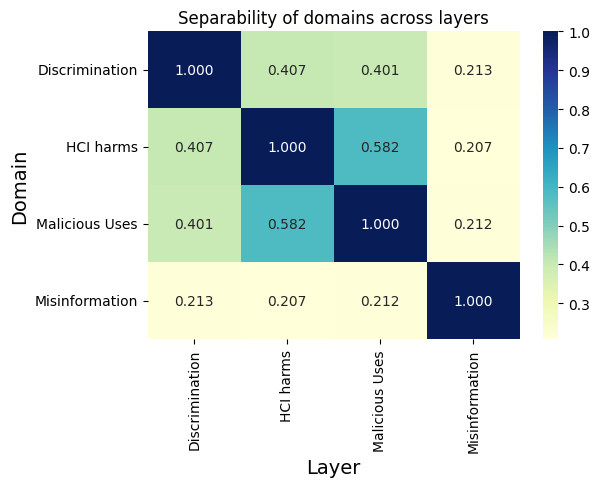

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(overlap_count_safe, annot=True, ax=ax, xticklabels=DOMAINS1, fmt=".3f", yticklabels=DOMAINS1, cmap="YlGnBu")
plt.xlabel("Layer", fontsize=14)
plt.ylabel("Domain", fontsize=14)
plt.title("Separability of domains across layers")
plt.show()

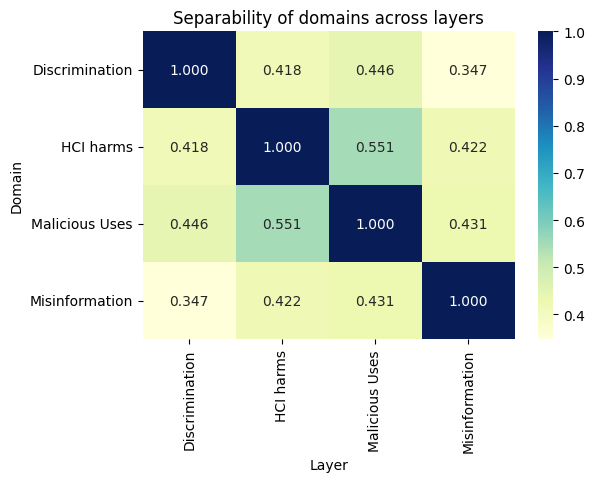

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(overlap_count_unsafe, annot=True, ax=ax, xticklabels=DOMAINS1, fmt=".3f", yticklabels=DOMAINS1, cmap="YlGnBu")
plt.xlabel("Layer")
plt.ylabel("Domain")
plt.title("Separability of domains across layers")
plt.show()

In [18]:
ood_overlap_count_safe = np.zeros((4,))
ood_overlap_count_unsafe = np.zeros((4,))

for i in range(4):
    merge_domain_text_safe = []
    merge_domain_text_unsafe = []
    for j in range(4):
        if i != j:
            merge_domain_text_safe.extend(domain_text[j][domain_text[j]["binary_label"] == 0]['text'].tolist())
            merge_domain_text_unsafe.extend(domain_text[j][domain_text[j]["binary_label"] == 1]['text'].tolist())
    merge_top_words_safe = top_tfidf_words(merge_domain_text_safe)
    merge_top_words_unsafe = top_tfidf_words(merge_domain_text_unsafe)
    ood_overlap_count_safe[i] = len(set(domain_topwords_safe[i]).intersection(set(merge_top_words_safe)))/len(domain_topwords_safe[i])
    ood_overlap_count_unsafe[i] = len(set(domain_topwords_unsafe[i]).intersection(set(merge_top_words_unsafe)))/len(domain_topwords_unsafe[i])


ood_overlap_count_safe, ood_overlap_count_unsafe

(array([0.421, 0.41 , 0.448, 0.214]), array([0.448, 0.475, 0.522, 0.42 ]))

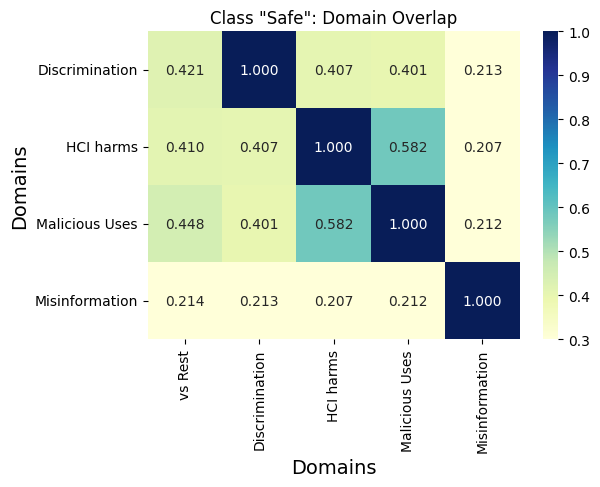

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

hmap = []
for i in range(4):
    hmap.append([ood_overlap_count_safe[i]] + overlap_count_safe[i].tolist())

fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(hmap, annot=True, ax=ax, xticklabels=["vs Rest"] + DOMAINS1, fmt=".3f", yticklabels=DOMAINS1, cmap="YlGnBu", vmin=0.3, vmax=1.0)
plt.xlabel("Domains", fontsize=14)
plt.ylabel("Domains", fontsize=14)
plt.title("Class \"Safe\": Domain Overlap")
plt.show()

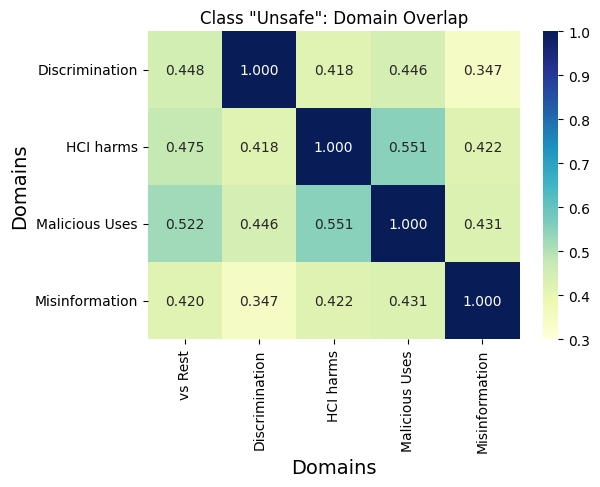

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

hmap = []
for i in range(4):
    hmap.append([ood_overlap_count_unsafe[i]] + overlap_count_unsafe[i].tolist())

fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(hmap, annot=True, ax=ax, xticklabels=["vs Rest"] + DOMAINS1, fmt=".3f", yticklabels=DOMAINS1, cmap="YlGnBu", vmin=0.3, vmax=1.0)
plt.xlabel("Domains", fontsize=14)
plt.ylabel("Domains", fontsize=14)
plt.title("Class \"Unsafe\": Domain Overlap")
plt.show()

In [22]:
hmap

[[0.421, 1.0, 0.407, 0.401, 0.213],
 [0.41, 0.407, 1.0, 0.582, 0.207],
 [0.448, 0.401, 0.582, 1.0, 0.212],
 [0.214, 0.213, 0.207, 0.212, 1.0]]

### Length

In [158]:
df = pd.read_csv("./data/domain_dataset.csv")


In [195]:
ll = []

for i in range(4):
   text = df.iloc[i*20000:(i+1)*20000][df["binary_label"]==0]['text'].tolist()
   ll.append([len(x.split()) for x in text])

/tmp/ipykernel_2190647/2184743454.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  text = df.iloc[i*20000:(i+1)*20000][df["binary_label"]==0]['text'].tolist()
/tmp/ipykernel_2190647/2184743454.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  text = df.iloc[i*20000:(i+1)*20000][df["binary_label"]==0]['text'].tolist()
/tmp/ipykernel_2190647/2184743454.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  text = df.iloc[i*20000:(i+1)*20000][df["binary_label"]==0]['text'].tolist()
/tmp/ipykernel_2190647/2184743454.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  text = df.iloc[i*20000:(i+1)*20000][df["binary_label"]==0]['text'].tolist()


In [193]:
ll1 = []

for i in range(4):
   text = df.iloc[i*20000:(i+1)*20000][df["binary_label"]==1]['text'].tolist()
   ll1.append([len(x.split()) for x in text])

/tmp/ipykernel_2190647/965709285.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  text = df.iloc[i*20000:(i+1)*20000][df["binary_label"]==1]['text'].tolist()
/tmp/ipykernel_2190647/965709285.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  text = df.iloc[i*20000:(i+1)*20000][df["binary_label"]==1]['text'].tolist()
/tmp/ipykernel_2190647/965709285.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  text = df.iloc[i*20000:(i+1)*20000][df["binary_label"]==1]['text'].tolist()
/tmp/ipykernel_2190647/965709285.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  text = df.iloc[i*20000:(i+1)*20000][df["binary_label"]==1]['text'].tolist()


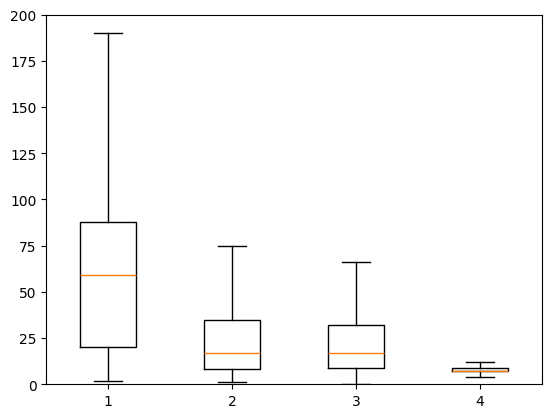

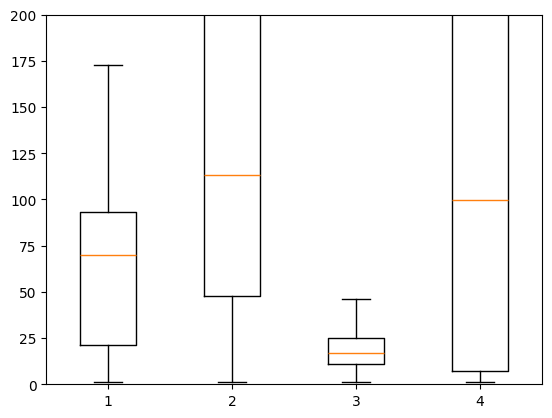

In [214]:
plt.boxplot(ll, showfliers=False)
plt.ylim(0,200)
plt.show()

plt.boxplot(ll1, showfliers=False)
plt.ylim(0,200)
plt.show()

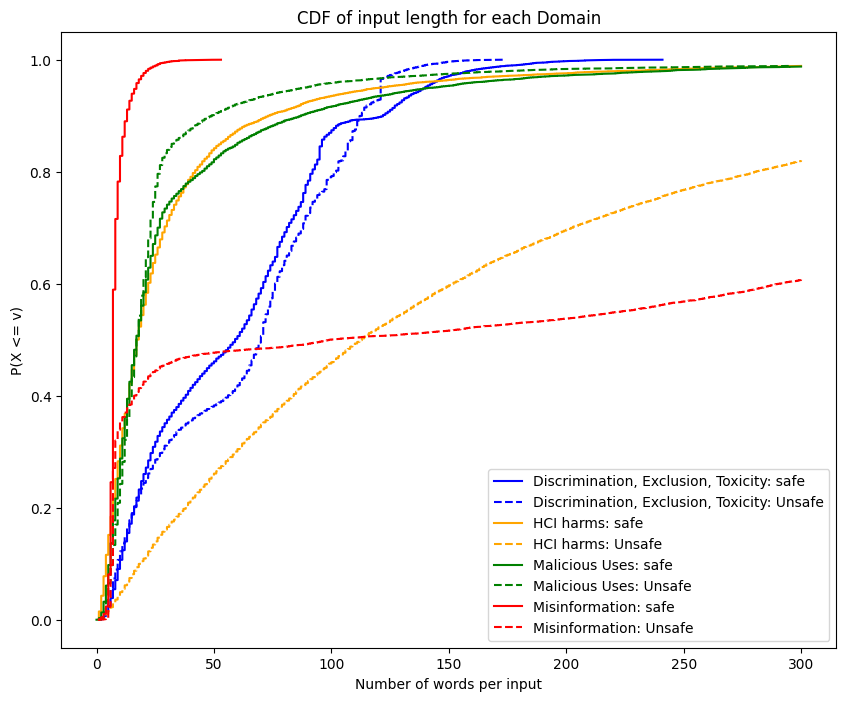

In [208]:
def calculate_cdf(array, plot_range):
    # Sort the full array
    sorted_array = np.sort(array)
    # Calculate the cumulative sum of probabilities
    cdf = np.arange(1, len(sorted_array) + 1) / len(sorted_array)
    # Limit the array and CDF to the plot range for plotting
    limited_sorted_array = sorted_array[(sorted_array >= plot_range[0]) & (sorted_array <= plot_range[1])]
    limited_cdf = cdf[(sorted_array >= plot_range[0]) & (sorted_array <= plot_range[1])]
    return limited_sorted_array, limited_cdf


DOMAINS = ["Discrimination, Exclusion, Toxicity", "HCI harms", "Malicious Uses", "Misinformation"]
domain2color = {"Discrimination, Exclusion, Toxicity": "blue", "HCI harms": "orange", "Malicious Uses": "green", "Misinformation": "red"}
plt.figure(figsize=(10, 8))
for i in range(4):
    sorted_array, cdf = calculate_cdf(ll[i], (-100, 300))
    plt.plot(sorted_array, cdf, label=DOMAINS[i] + ": safe", c=domain2color[DOMAINS[i]])
    sorted_array, cdf = calculate_cdf(ll1[i], (-100, 300))
    plt.plot(sorted_array, cdf, label=DOMAINS[i] + ": Unsafe", linestyle='--', c=domain2color[DOMAINS[i]])

plt.xlabel("Number of words per input")
plt.ylabel("P(X <= v)")
plt.title("CDF of input length for each Domain")
plt.legend()
plt.show()